In [ ]:
%load_ext autoreload
%autoreload 2

# Open3D PreProcessing

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from lib.data.metainfo import MetaInfo
from lib.visualize.open3d import visualize_object, visualize_pointcloud
from lib.data.preprocess import PreprocessSDF, PreprocessMesh, PreprocessSiamese


data_dir = "/home/borth/sketch2shape/data/shapenet_chair_1024"
metainfo = MetaInfo(data_dir=data_dir)
# obj_id = metainfo.obj_ids[0]
obj_id = "5b1744a03be753cf3ccbceb68fb352fd"

## Load And Normalize

In [ ]:
mesh = PreprocessMesh(data_dir=data_dir)
normalized_mesh = mesh.preprocess(obj_id)
visualize_object(normalized_mesh)

## Sphere Tracing and Normals Map

In [ ]:
siamese = PreprocessSiamese(
    data_dir=data_dir,
    azims=[45],
    elevs=[-45],
)
normals, sketches = siamese.preprocess(obj_id=obj_id)
plt.imshow(normals[0])

# Sample SDF 

In [ ]:
sdf = PreprocessSDF(
    data_dir=data_dir,
    azims=[0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330],
    elevs=[-90, -60, -30, 0, 30, 60,  90],
)
sdf_samples, surface_samples = sdf.preprocess(obj_id=obj_id)
visualize_pointcloud(surface_samples)

In [ ]:
visualize_pointcloud(sdf_samples[:, :3], sdf_samples[:, 3])

In [ ]:
points, sdfs = metainfo.load_sdf_samples(obj_id)
mask = np.random.choice(500000, 10000)
mask = sdfs < 0
visualize_pointcloud(points[mask], sdfs[mask])

In [ ]:
(points[mask][:, 1] > 0.2).sum()

In [ ]:
x = np.load("/shared/data/ShapeNetV2/SdfSamples/overfit_1/03001627/787a4db5b3452fc357a847db7547c1f3.npz")
pos = x["pos"]
neg = x["neg"]
points = np.concatenate([pos[:, :3], neg[:, :3]])
sdfs = np.concatenate([pos[:, 3], neg[:, 3]])
visualize_pointcloud(points, sdfs)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from lib.data.metainfo import MetaInfo
from lib.visualize.open3d import visualize_object, visualize_pointcloud
from lib.data.preprocess import PreprocessSDF, PreprocessMesh, PreprocessSiamese


data_dir = "/home/borth/sketch2shape/data/shapenet_chair_1024"
metainfo = MetaInfo(data_dir=data_dir)
obj_id = "5b1744a03be753cf3ccbceb68fb352fd"
sdf = PreprocessSDF(
    cloud_samples=500000,
    inside_delta_var=1e-01, 
    data_dir=data_dir,
    azims=[0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330],
    elevs=[-90, -60, -30, 0, 30, 60,  90],
)
sdf.load(obj_id=obj_id)
points, sdfs = sdf.sample_surface()
points.shape

In [ ]:
import point_cloud_utils as pcu
import matplotlib.pyplot as plt
import numpy as np
from lib.data.metainfo import MetaInfo
from lib.visualize.open3d import visualize_object, visualize_pointcloud
from lib.data.preprocess import PreprocessSDF, PreprocessMesh, PreprocessSiamese
import open3d as o3d


data_dir = "/home/borth/sketch2shape/data/shapenet_chair_1024"
metainfo = MetaInfo(data_dir=data_dir)
obj_id = metainfo.obj_ids[4]

In [ ]:
def smooth_watertight_mesh(mesh, resolution: int = 10000, num_iters: int = 1):
    # extract verts and faces
    verts = np.asarray(mesh.vertices)
    faces = np.asarray(mesh.triangles)
    # watertight and smooth, note that it's not watertight
    vw, fw = pcu.make_mesh_watertight(verts, faces, resolution)
    vw = pcu.laplacian_smooth_mesh(
        vw, fw, num_iters=num_iters, use_cotan_weights=True
    )
    # translate back to open3d mesh
    verts = o3d.utility.Vector3dVector(vw)
    faces = o3d.utility.Vector3iVector(fw) 
    mesh = o3d.geometry.TriangleMesh(verts, faces)

    # normalize mesh
    points = np.asarray(mesh.vertices)
    translate = (np.min(points, axis=0) + np.max(points, axis=0)) / 2.0
    points -= translate
    points /= np.linalg.norm(points, axis=-1).max()
    mesh.vertices = o3d.utility.Vector3dVector(points)

    return mesh

mesh = metainfo.load_normalized_mesh(obj_id=obj_id)
sw_mesh = smooth_watertight_mesh(mesh, resolution=20000)
visualize_object(sw_mesh)

In [ ]:
mesh = metainfo.load_normalized_mesh(obj_id=obj_id)
visualize_object(mesh)

In [ ]:
def random_cube_samples(num_samples):
    circle = o3d.geometry.TriangleMesh.create_sphere()
    point_cloud = circle.sample_points_uniformly(100000)
    points = np.asarray(point_cloud.points)
    points = points / np.linalg.norm(points, axis=-1)[..., None]
    radius = np.random.beta(2, 0.5, points.shape[0])
    points = points * radius[..., None]
    return points

def get_sdf(query, mesh):
    query_point = o3d.core.Tensor(query, dtype=o3d.core.Dtype.Float32)
    scene = o3d.t.geometry.RaycastingScene()
    _mesh = o3d.t.geometry.TriangleMesh.from_legacy(mesh)
    _ = scene.add_triangles(_mesh)
    return scene.compute_signed_distance(query_point).numpy()

query = random_cube_samples(100000)  # sample points in the unit cube
sdf = get_sdf(query, mesh)  # get the sdf values from the points w.r.t mesh
mask = (sdf < 0)  # only show the points inside the surface
visualize_pointcloud(query[mask], sdf[mask])  # visualize

In [ ]:
query = random_cube_samples(500000)  # sample points in the unit cube
sdf = get_sdf(query, sw_mesh)  # get the sdf values from the points w.r.t mesh
mask = (sdf < 0)  # only show the points inside the surface
visualize_pointcloud(query[mask], sdf[mask])  # visualize

In [ ]:
scene = o3d.t.geometry.RaycastingScene()
_mesh = o3d.t.geometry.TriangleMesh.from_legacy(mesh)  # NOTE add here the mesh
_ = scene.add_triangles(_mesh)

min_bound = _mesh.vertex.positions.min(0).numpy()
max_bound = _mesh.vertex.positions.max(0).numpy()

N = 256
query_points = np.random.uniform(low=min_bound, high=max_bound,
                                 size=[N, 3]).astype(np.float32)

# Compute the signed distance for N random points
signed_distance = scene.compute_signed_distance(query_points)
xyz_range = np.linspace(min_bound, max_bound, num=32)

# query_points is a [32,32,32,3] array ..
query_points = np.stack(np.meshgrid(*xyz_range.T), axis=-1).astype(np.float32)

# signed distance is a [32,32,32] array
signed_distance = scene.compute_signed_distance(query_points)
# signed_distance = signed_distance < 0

# We can visualize a slice of the distance field directly with matplotlib
plt.imshow(signed_distance.numpy()[10, :, :])  # NOTE show slices

In [ ]:
for obj_id in metainfo.obj_ids[10:20]:
    mesh = metainfo.load_normalized_mesh(obj_id=obj_id)
    sw_mesh = smooth_watertight_mesh(mesh, resolution=20000)
    query = random_cube_samples(500000)  # sample points in the unit cube
    sdf = get_sdf(query, sw_mesh)  # get the sdf values from the points w.r.t mesh
    mask = (sdf < 0)  # only show the points inside the surface
    visualize_pointcloud(query[mask], sdf[mask])  # visualize

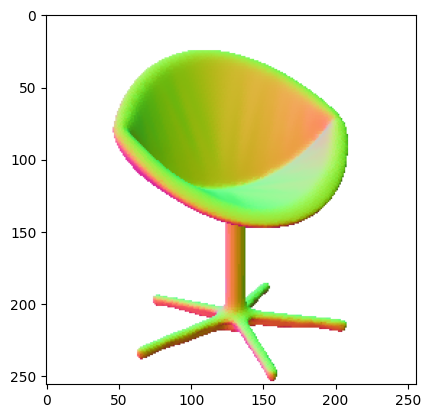

In [128]:
from lib.render.mesh import render_normals
mesh = metainfo.load_normalized_mesh(obj_id="6d6e634ff34bd350c511e6b9b3b344f3")
sw_mesh = smooth_watertight_mesh(mesh, resolution=20000, num_iters=2)
_, normals, mask = render_normals(
    mesh=sw_mesh,
    azims=[40],
    elevs=[-15],
    dist=4,
    width=256,
    height=256,
    focal = 512,
    sphere_eps = 1e-1,
)
normals = (normals + 1) / 2
normals[~mask] = 1
normals = normals.reshape(normals.shape[0], 256, 256, -1)
# normals = (normals * 255).astype(np.uint8)
plt.imshow(normals[0])

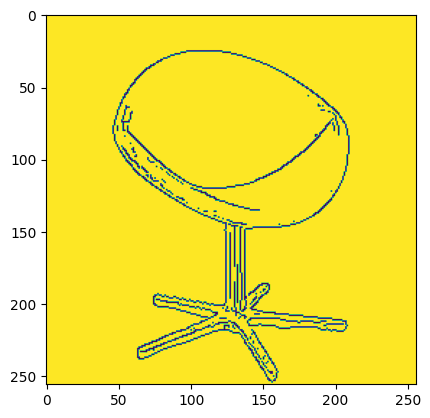

In [139]:
import cv2 as cv
_normals = (normals * 255).astype(np.uint8)
edges = []
edge = cv.Canny(
    _normals[0],
    100,
    150,
    L2gradient=True,
)
edge = cv.bitwise_not(edge)
_edge = np.stack([edge, edge, edge])
plt.imshow(_edge)

(3, 256, 256)